In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
csv_akam = "C:/Business analysis/Project/IS403.O22.HTCLL_Nhom07/Dataset/AKAM_Stock.csv"
df_akam = pd.read_csv(csv_akam, thousands=',')

In [3]:
df_akam.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,3/1/2019,AKAM,71.089996,71.089996,71.489998,69.739998,70.059998,1633700
1,3/4/2019,AKAM,70.290001,70.290001,71.790001,69.709999,71.550003,995000
2,3/5/2019,AKAM,70.550003,70.550003,70.989998,69.800003,70.209999,1282100
3,3/6/2019,AKAM,71.540001,71.540001,71.680000,70.510002,70.620003,1658400
4,3/7/2019,AKAM,70.470001,70.470001,71.150002,70.019997,71.089996,1353400


In [4]:
df_akam.describe()

,Adj Close,Close,High,Low,Open,Volume
count,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1.324000e+03
mean,98.894456,98.894456,99.920030,97.838044,98.871488,1.582324e+06
std,13.155544,13.155544,13.238076,13.092423,13.186564,9.565868e+05
min,69.120003,69.120003,69.260002,67.279999,68.230003,2.774000e+05
25%,88.715000,88.715000,89.742500,87.667500,88.660004,1.043800e+06
50%,100.404999,100.404999,101.779999,99.184998,100.419998,1.350500e+06
75%,110.002501,110.002501,111.330000,108.862501,109.972502,1.799050e+06
max,128.320007,128.320007,129.169998,126.980003,128.550003,1.077170e+07


In [5]:
df_akam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1324 non-null   object 
 1   Symbol     1324 non-null   object 
 2   Adj Close  1324 non-null   float64
 3   Close      1324 non-null   float64
 4   High       1324 non-null   float64
 5   Low        1324 non-null   float64
 6   Open       1324 non-null   float64
 7   Volume     1324 non-null   int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 82.9+ KB


In [6]:
# Convert object to datetime64
df_akam['Date'] = df_akam['Date'].apply(pd.to_datetime)
# Sort data by date time value
df_akam = df_akam.sort_values(by="Date").reset_index(drop=True)
df_akam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1324 non-null   datetime64[ns]
 1   Symbol     1324 non-null   object        
 2   Adj Close  1324 non-null   float64       
 3   Close      1324 non-null   float64       
 4   High       1324 non-null   float64       
 5   Low        1324 non-null   float64       
 6   Open       1324 non-null   float64       
 7   Volume     1324 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 82.9+ KB


In [7]:
df_akam.Close

0       71.089996
1       70.290001
2       70.550003
3       71.540001
4       70.470001
          ...    
1319    92.589996
1320    90.839996
1321    90.220001
1322    92.239998
1323    90.900002
Name: Close, Length: 1324, dtype: float64

In [8]:
rows = []
for _,row in tqdm(df_akam.iterrows(), total=df_akam.shape[0]):
    row_data = dict(
        day = row.Date.day,
        month = row.Date.month,
        year = row.Date.year,
        open = row.Open,
        low = row.Close,
        high = row.High, 
        close = row.Close, 
        volume = row.Volume
    )
    rows.append(row_data)
features_akam = pd.DataFrame(rows)

  0%|          | 0/1324 [00:00<?, ?it/s]

In [9]:
features_akam.head()

,day,month,year,open,low,high,close,volume
0,1,3,2019,70.059998,71.089996,71.489998,71.089996,1633700
1,4,3,2019,71.550003,70.290001,71.790001,70.290001,995000
2,5,3,2019,70.209999,70.550003,70.989998,70.550003,1282100
3,6,3,2019,70.620003,71.540001,71.680000,71.540001,1658400
4,7,3,2019,71.089996,70.470001,71.150002,70.470001,1353400


In [10]:
def detect_outlier(df, col):
    q1 = np.percentile(df[col], 25)
    q3 = np.percentile(df[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    print(df[(df[col] < lower_bound) | (df[col] > upper_bound)])

In [11]:
detect_outlier(features_akam, 'close')

Empty DataFrame
Columns: [day, month, year, open, low, high, close, volume]
Index: []


In [12]:
train_size = int(0.75 * len(features_akam))
test_size = len(features_akam)-train_size

train_akam_df = features_akam[:train_size]
test_akam_df = features_akam[train_size:]

In [13]:
#Quá trình Training
x_train = np.array(train_akam_df.index).reshape(-1, 1)
y_train = np.array(train_akam_df['close'])
# Train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)
# In các thông số của mô hình
print("Hệ số hồi quy (slope):", model.coef_)
print("Sai số chệch (intercept):", model.intercept_)

Hệ số hồi quy (slope): [0.0161627]
Sai số chệch (intercept): 90.67792351875974


In [14]:
#Quá trình testing
x_test = np.array(test_akam_df.index).reshape(-1, 1)
y_test = np.array(test_akam_df['close'])
y_pred = model.predict(x_test)

In [15]:
#Quá trình tạo index predict 30 ngày tiếp theo
last_index = features_akam.index[-1]
last_30_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(x_next_30_days)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[112.07733762 112.09350032 112.10966302 112.12582572 112.14198842
 112.15815112 112.17431382 112.19047652 112.20663922 112.22280192
 112.23896462 112.25512732 112.27129002 112.28745272 112.30361542
 112.31977811 112.33594081 112.35210351 112.36826621 112.38442891
 112.40059161 112.41675431 112.43291701 112.44907971 112.46524241
 112.48140511 112.49756781 112.51373051 112.52989321 112.54605591]


In [16]:
#Quá trình tạo index predict 60 ngày tiếp theo
last_index = features_akam.index[-1]
last_60_data = pd.RangeIndex(start=last_index, stop=last_index+60, step=1)

# Create an array of 60 consecutive integers starting from last_index
x_next_60_days = np.array(range(last_index+1, last_index+61)).reshape(-1, 1)

# Predict the closing prices for the next 60 days
y_next_60_days = model.predict(x_next_60_days)

# Print the predicted closing prices for the next 60 days
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days)

Predicted closing prices for the next 60 days:
[112.07733762 112.09350032 112.10966302 112.12582572 112.14198842
 112.15815112 112.17431382 112.19047652 112.20663922 112.22280192
 112.23896462 112.25512732 112.27129002 112.28745272 112.30361542
 112.31977811 112.33594081 112.35210351 112.36826621 112.38442891
 112.40059161 112.41675431 112.43291701 112.44907971 112.46524241
 112.48140511 112.49756781 112.51373051 112.52989321 112.54605591
 112.56221861 112.57838131 112.59454401 112.61070671 112.6268694
 112.6430321  112.6591948  112.6753575  112.6915202  112.7076829
 112.7238456  112.7400083  112.756171   112.7723337  112.7884964
 112.8046591  112.8208218  112.8369845  112.8531472  112.8693099
 112.8854726  112.9016353  112.917798   112.93396069 112.95012339
 112.96628609 112.98244879 112.99861149 113.01477419 113.03093689]


In [17]:
#Quá trình tạo index predict 90 ngày tiếp theo
last_index = features_akam.index[-1]
last_90_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)

# Create an array of 90 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_90_days = model.predict(x_next_90_days)

# Print the predicted closing prices for the next 90 days
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)

Predicted closing prices for the next 90 days:
[112.07733762 112.09350032 112.10966302 112.12582572 112.14198842
 112.15815112 112.17431382 112.19047652 112.20663922 112.22280192
 112.23896462 112.25512732 112.27129002 112.28745272 112.30361542
 112.31977811 112.33594081 112.35210351 112.36826621 112.38442891
 112.40059161 112.41675431 112.43291701 112.44907971 112.46524241
 112.48140511 112.49756781 112.51373051 112.52989321 112.54605591
 112.56221861 112.57838131 112.59454401 112.61070671 112.6268694
 112.6430321  112.6591948  112.6753575  112.6915202  112.7076829
 112.7238456  112.7400083  112.756171   112.7723337  112.7884964
 112.8046591  112.8208218  112.8369845  112.8531472  112.8693099
 112.8854726  112.9016353  112.917798   112.93396069 112.95012339
 112.96628609 112.98244879 112.99861149 113.01477419 113.03093689
 113.04709959 113.06326229 113.07942499 113.09558769 113.11175039
 113.12791309 113.14407579 113.16023849 113.17640119 113.19256389
 113.20872659 113.22488929 113.24

In [18]:
#Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
print('Testing MAE:', test_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
print('Testing MAPE:', test_mape)

Testing RMSE: 16.381530019885147
Testing MAE: 13.042283777690413
Testing MAPE: 0.14769947973968675


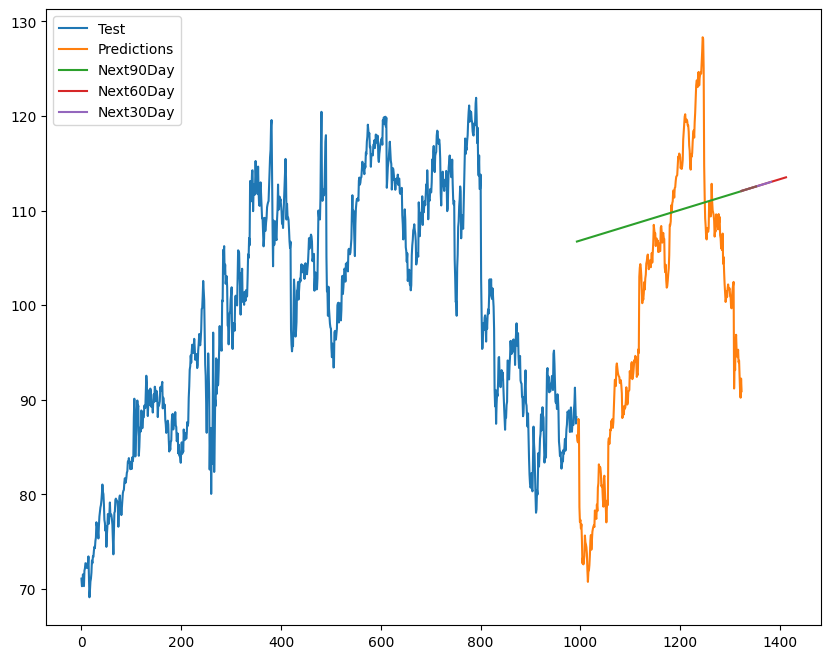

In [19]:
#Vẽ hình
plt.figure(figsize=(10, 8))
plt.plot(train_akam_df.index, train_akam_df['close'])
plt.plot(test_akam_df.index, test_akam_df['close'])
plt.plot(test_akam_df.index, y_pred)
plt.plot(last_90_data,y_next_90_days)
plt.plot(last_60_data,y_next_60_days)
plt.plot(last_30_data,y_next_30_days)
plt.legend(['Test', 'Predictions','Next90Day','Next60Day','Next30Day'])
plt.show()

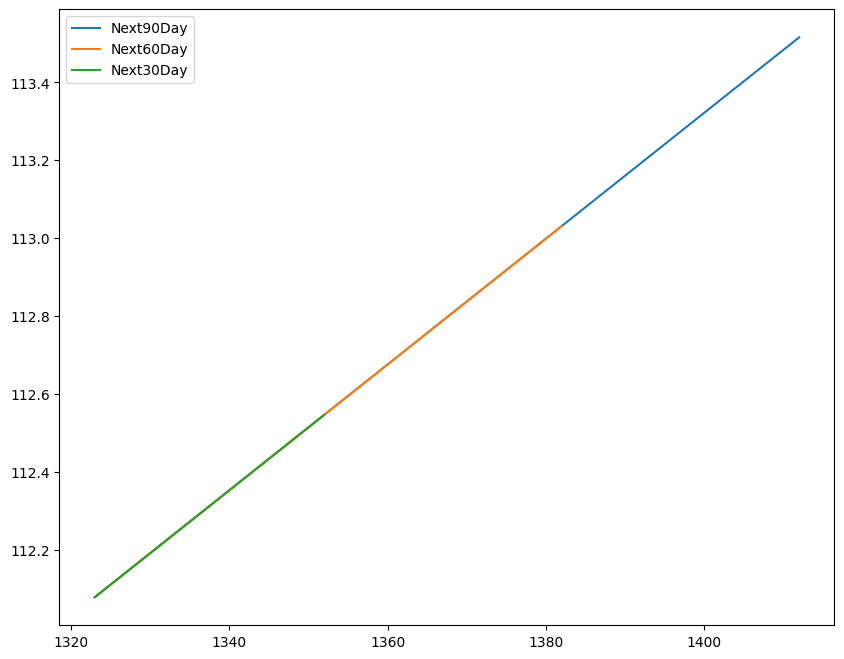

In [20]:
plt.figure(figsize=(10, 8))
plt.plot(last_90_data,y_next_90_days)
plt.plot(last_60_data,y_next_60_days)
plt.plot(last_30_data,y_next_30_days)
plt.legend(['Next90Day','Next60Day','Next30Day'])
plt.show()